In [1]:
from parameters import get_parameters

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from arch.unitroot import PhillipsPerron

In [2]:
params = get_parameters()
target = params["target"]
source_conformed = params["source_conformed"]

PROJECT_ROOT = Path().resolve().parent
print(f"Project root: {PROJECT_ROOT}")

Project root: C:\Users\dxnin\Documents\dengue-forecast


In [3]:
df = pd.read_pickle(f"{PROJECT_ROOT}/{source_conformed}/data.pkl")
df.head()

,CASES,PRECIPITATION_AVG_MAX,RUNOFF_AVG_MAX,TEMPERATURE_AVG_MAX,WIND_AVG_MAX
DATE,,,,,
2007-01-07,0,0.829115,0.057710,21.954080,2.847873
2007-01-14,0,4.017773,0.367180,22.923341,3.972641
2007-01-21,0,8.691750,1.045510,23.034158,3.766555
2007-01-28,0,13.806932,1.639757,24.142465,4.537634
2007-02-04,0,1.075573,0.077687,26.059118,5.366861


## Plot of all variables

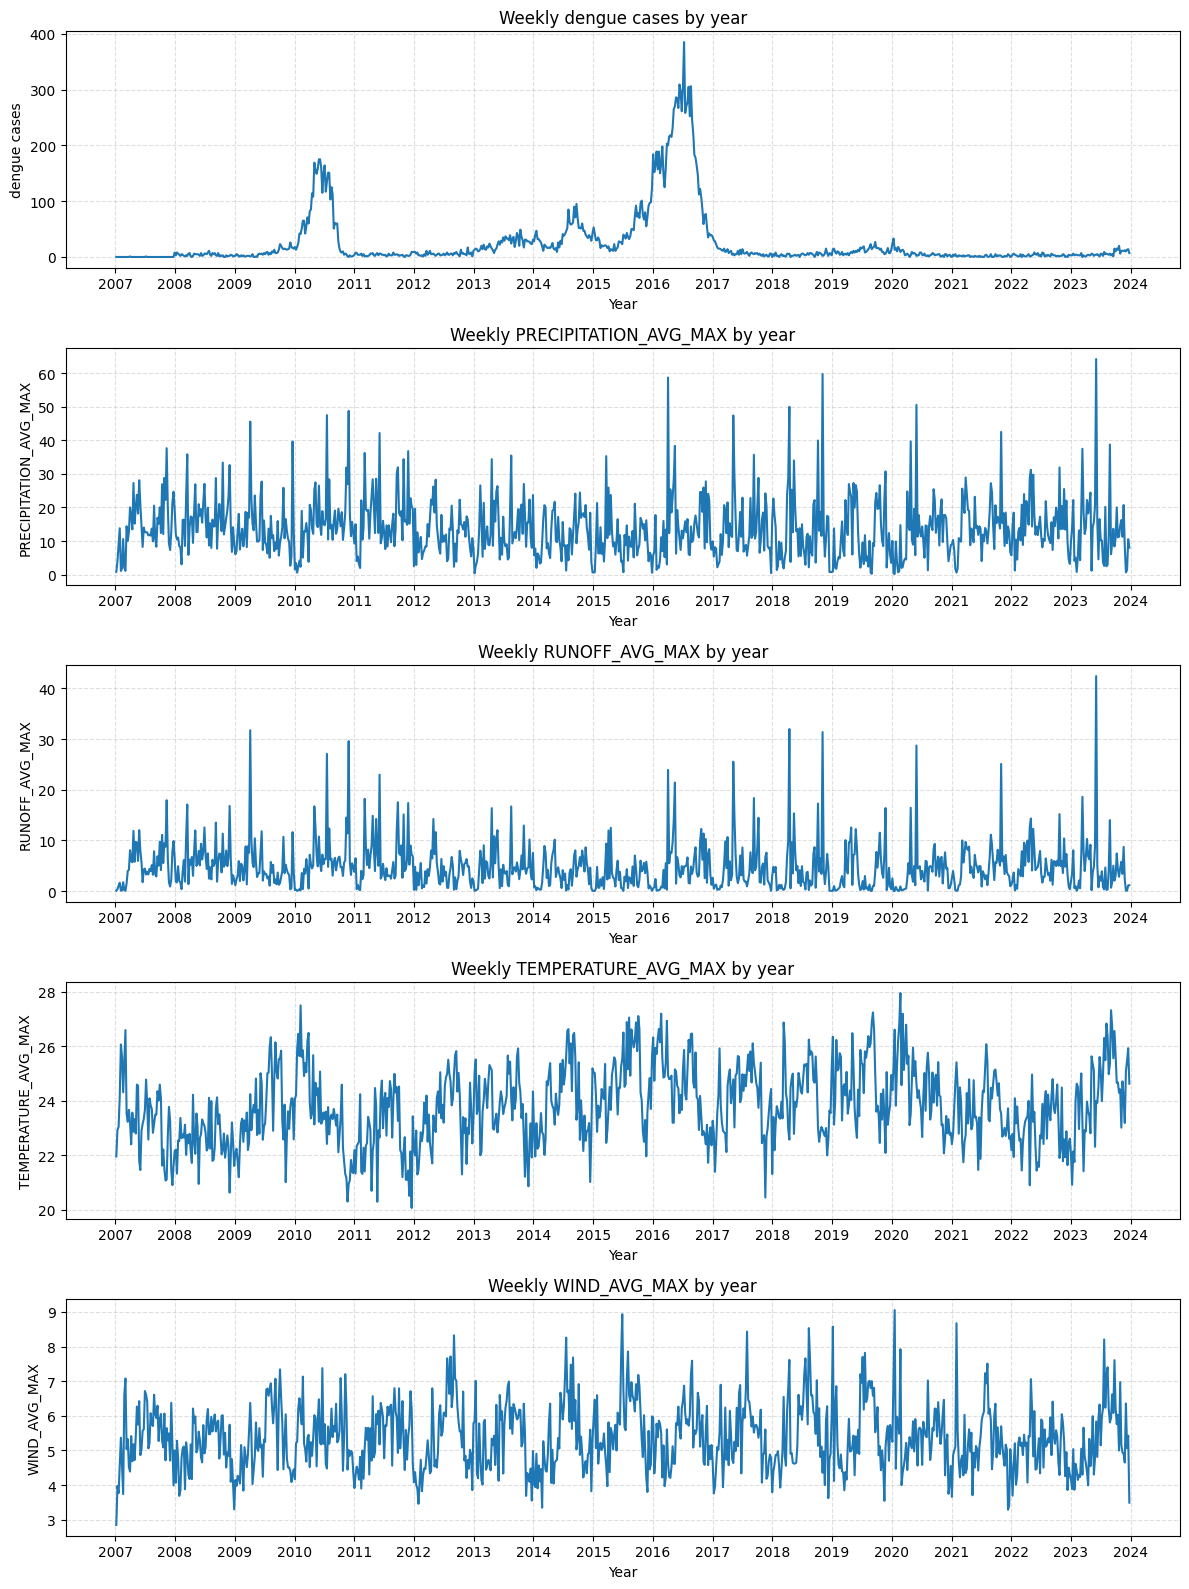

In [4]:
pretty_info = {
    'CASES': ('dengue cases', ''),
    'TEMPERATURE_MAX': ('maximum temperature', '°C'),
    'RUNOFF_MAX': ('maximum surface runoff', 'L/m²'),
    'PRECIPITATION_MAX': ('maximum precipitation', 'L/m²'),
    'WIND_MAX': ('maximum wind', 'km/h')
}

def plot_all_series(df, target_col='target'):
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    cols_to_plot = [c for c in df.columns if c != target_col]
    n = len(cols_to_plot)

    fig, axes = plt.subplots(n, 1, figsize=(12, 3.2 * n), sharex=False)  # <-- changed here

    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, cols_to_plot):
        ax.plot(df.index, df[col], linewidth=1.5)

        # Format x-axis to show years in every subplot
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        plt.setp(ax.get_xticklabels(), rotation=0)  # keep year labels horizontal

        # Add grid and labels
        ax.grid(True, linestyle='--', alpha=0.4)

        # Label + unit
        label, unit = pretty_info.get(col, (col, ''))
        ax.set_title(f'Weekly {label} by year', fontsize=12)
        ax.set_ylabel(f'{label} ({unit})' if unit else label)
        ax.set_xlabel('Year')

    plt.tight_layout()
    plt.show()


plot_all_series(df, target_col='target')

## General summary

In [5]:
df.shape

(886, 5)

In [6]:
sum(df[target])

22441

In [7]:
# Number and percentage of weeks with zero dengue cases
zero_case_weeks = (df[target] == 0).sum()
total_weeks = len(df)
percentage_zero_case_weeks = (zero_case_weeks / total_weeks) * 100
print(f"Number of weeks with zero dengue cases: {zero_case_weeks}")
print(f"Percentage of weeks with zero dengue cases: {percentage_zero_case_weeks:.2f}%")

Number of weeks with zero dengue cases: 81
Percentage of weeks with zero dengue cases: 9.14%


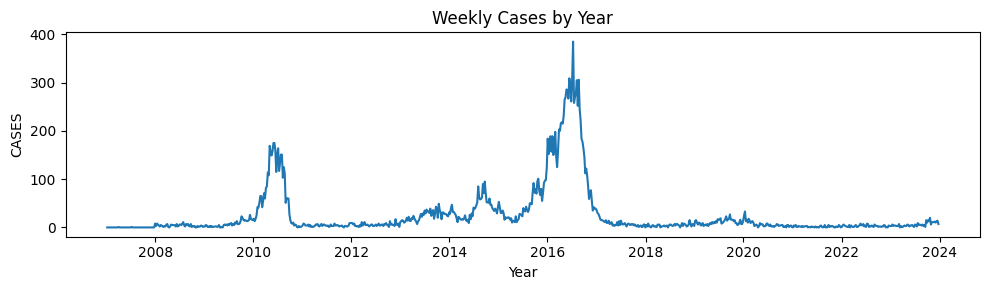

In [8]:
df.index = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(df.index, df[target])
plt.xlabel('Year')
plt.ylabel(target)
plt.title('Weekly Cases by Year')
plt.tight_layout()
plt.show()

In [9]:
df.columns

Index(['CASES', 'PRECIPITATION_AVG_MAX', 'RUNOFF_AVG_MAX',
       'TEMPERATURE_AVG_MAX', 'WIND_AVG_MAX'],
      dtype='object')

In [10]:
# Summary statistics
for i in df.columns:
    print(f"Summary statistics for {i}:")
    print(df[i].describe())
    print("\n", "="*40, "\n")

Summary statistics for CASES:
count    886.000000
mean      25.328442
std       52.444789
min        0.000000
25%        3.000000
50%        6.000000
75%       18.000000
max      385.000000
Name: CASES, dtype: float64


Summary statistics for PRECIPITATION_AVG_MAX:
count    886.000000
mean      13.787080
std        8.621176
min        0.191122
25%        8.284162
50%       12.620534
75%       18.124637
max       64.173184
Name: PRECIPITATION_AVG_MAX, dtype: float64


Summary statistics for RUNOFF_AVG_MAX:
count    886.000000
mean       4.777432
std        4.571735
min        0.010446
25%        1.666767
50%        3.936997
75%        6.287814
max       42.421658
Name: RUNOFF_AVG_MAX, dtype: float64


Summary statistics for TEMPERATURE_AVG_MAX:
count    886.000000
mean      23.810616
std        1.388001
min       20.065164
25%       22.805372
50%       23.727308
75%       24.797933
max       27.942342
Name: TEMPERATURE_AVG_MAX, dtype: float64


Summary statistics for WIND_AVG_MAX:
count

In [11]:
# Total dengue cases
print("Total dengue cases:", sum(df.CASES))

Total dengue cases: 22441


In [12]:
# Total dengue cases per year
for i in range(2007, 2023 + 1):
    print(f"Year {i}: {sum(df[target][df[target].index.year == i])} dengue cases")

Year 2007: 10 dengue cases
Year 2008: 195 dengue cases
Year 2009: 393 dengue cases
Year 2010: 3743 dengue cases
Year 2011: 207 dengue cases
Year 2012: 296 dengue cases
Year 2013: 1259 dengue cases
Year 2014: 2000 dengue cases
Year 2015: 2340 dengue cases
Year 2016: 9848 dengue cases
Year 2017: 470 dengue cases
Year 2018: 219 dengue cases
Year 2019: 578 dengue cases
Year 2020: 330 dengue cases
Year 2021: 87 dengue cases
Year 2022: 154 dengue cases
Year 2023: 312 dengue cases


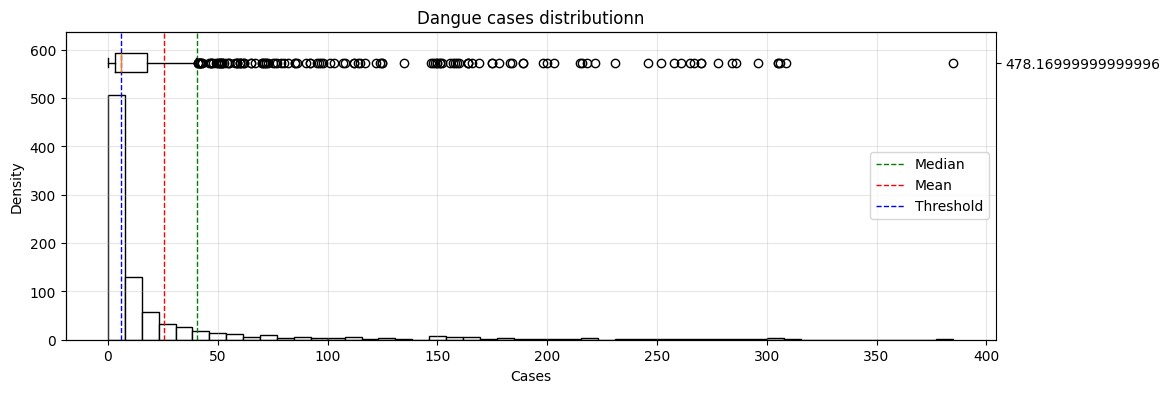

In [13]:
# Stats
Q1 = df['CASES'].quantile(0.25)
Q3 = df['CASES'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
mean_value = df['CASES'].mean()
median_value = df['CASES'].median()

x = df['CASES']

plt.figure(figsize=(12,4))
ax = plt.gca()

# Histograma
counts, bins, patches = ax.hist(x, bins=50, color='white', edgecolor='black')
ax.axvline(threshold, color='green', linestyle='dashed', linewidth=1)
ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
ax.axvline(median_value, color='blue', linestyle='dashed', linewidth=1)

ax.set_xlabel("Cases")
ax.set_ylabel("Density")
ax.set_title("Dangue cases distributionn")
ax.grid(True, alpha=0.3)

# ---- TRUCO: segundo eje Y invisible pero alineado ----
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())  # misma escala Y del histograma
ax2.set_yticks([])           # ocultar ticks
ax2.spines['right'].set_visible(False)

# Posición del boxplot arriba
y0, y1 = ax.get_ylim()
ax.set_ylim(y0, y1 * 1.2)

y_box = ax.get_ylim()[1] * 0.75

ax2.boxplot(
    x,
    vert=False,
    positions=[y_box],
    widths=[ax.get_ylim()[1] * 0.05]
)

ax.legend(
    ["Median", "Mean", "Threshold"],
    loc="center right"
)

plt.show()


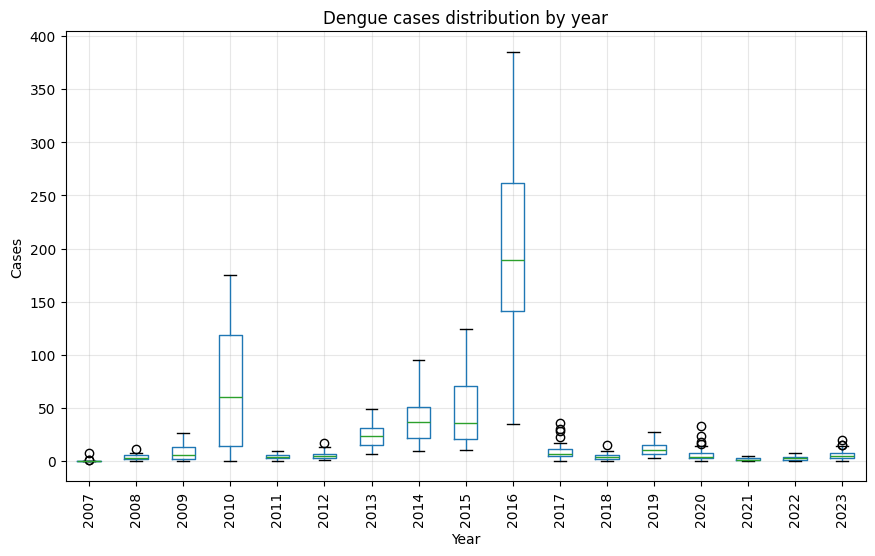

In [14]:
df['year'] = df.index.year

df.boxplot(column='CASES', by='year', grid=True, figsize=(10, 6))

plt.title("Dengue cases distribution by year")
plt.suptitle("")
plt.xlabel("Year")
plt.ylabel("Cases")
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.show()

## Dengue analysis

In [15]:
# df["CASES"] = np.log1p(df["CASES"])
# df["CASES"] = df["CASES"].diff().diff()
# df = df.dropna()

In [16]:
# Series
s0 = df[target]
s1 = df[target].diff().dropna()
s2 = df[target].diff().diff().dropna()

series_list = [s0, s1, s2]
titles = ["Original", "Diff 1", "Diff 2"]

In [17]:
def get_stats(series):
    # ADF
    adf = adfuller(series, autolag='AIC')
    adf_stat = adf[0]
    adf_crit5 = adf[4]['5%']
    adf_crit1 = adf[4]['1%']

    # KPSS
    kpss_res = kpss(series, regression='c', nlags="auto")
    kpss_stat = kpss_res[0]
    kpss_crit5 = kpss_res[3]['5%']
    kpss_crit1 = kpss_res[3]['1%']

    # PP
    pp = PhillipsPerron(series)
    pp_stat = pp.stat
    pp_crit5 = pp.critical_values['5%']
    pp_crit1 = pp.critical_values['1%']

    return [
        adf_stat, adf_crit5, adf_crit1,
        kpss_stat, kpss_crit5, kpss_crit1,
        pp_stat, pp_crit5, pp_crit1
    ]


def highlighter(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)

    for idx in df.index:
        # Extract needed stats
        adf_stat = df.loc[idx, 'ADF Statistic']
        adf_c5 = df.loc[idx, 'ADF Critical 5%']
        adf_c1 = df.loc[idx, 'ADF Critical 1%']

        kpss_stat = df.loc[idx, 'KPSS Statistic']
        kpss_c5 = df.loc[idx, 'KPSS Critical 5%']
        kpss_c1 = df.loc[idx, 'KPSS Critical 1%']

        pp_stat = df.loc[idx, 'PP Statistic']
        pp_c5 = df.loc[idx, 'PP Critical 5%']
        pp_c1 = df.loc[idx, 'PP Critical 1%']

        # ADF → stationary if stat < crit
        if adf_stat < adf_c5:
            styles.loc[idx, 'ADF Critical 5%'] = "background-color: lightgreen; color: black"
        if adf_stat < adf_c1:
            styles.loc[idx, 'ADF Critical 1%'] = "background-color: lightgreen; color: black"

        # KPSS → stationary if stat < crit
        if kpss_stat < kpss_c5:
            styles.loc[idx, 'KPSS Critical 5%'] = "background-color: lightgreen; color: black"
        if kpss_stat < kpss_c1:
            styles.loc[idx, 'KPSS Critical 1%'] = "background-color: lightgreen; color: black"

        # PP → stationary if stat < crit
        if pp_stat < pp_c5:
            styles.loc[idx, 'PP Critical 5%'] = "background-color: lightgreen; color: black"
        if pp_stat < pp_c1:
            styles.loc[idx, 'PP Critical 1%'] = "background-color: lightgreen; color: black"

    return styles

# Build table
results = pd.DataFrame(
    [
        get_stats(s0),
        get_stats(s1),
        get_stats(s2)
    ],
    index=["Original", "Diff 1", "Diff 2"],
    columns=[
        "ADF Statistic", "ADF Critical 5%", "ADF Critical 1%",
        "KPSS Statistic", "KPSS Critical 5%", "KPSS Critical 1%",
        "PP Statistic", "PP Critical 5%", "PP Critical 1%"
    ]
).round(4)

# Display
display(results.style.apply(highlighter, axis=None).format("{:.2f}"))

C:\Users\dxnin\AppData\Local\Temp\ipykernel_13864\2319566104.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, regression='c', nlags="auto")
C:\Users\dxnin\AppData\Local\Temp\ipykernel_13864\2319566104.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, regression='c', nlags="auto")
C:\Users\dxnin\AppData\Local\Temp\ipykernel_13864\2319566104.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, regression='c', nlags="auto")


,ADF Statistic,ADF Critical 5%,ADF Critical 1%,KPSS Statistic,KPSS Critical 5%,KPSS Critical 1%,PP Statistic,PP Critical 5%,PP Critical 1%
Original,-3.70,-2.86,-3.44,0.28,0.46,0.74,-3.55,-2.86,-3.44
Diff 1,-6.63,-2.86,-3.44,0.03,0.46,0.74,-37.35,-2.86,-3.44
Diff 2,-9.15,-2.86,-3.44,0.01,0.46,0.74,-188.97,-2.86,-3.44


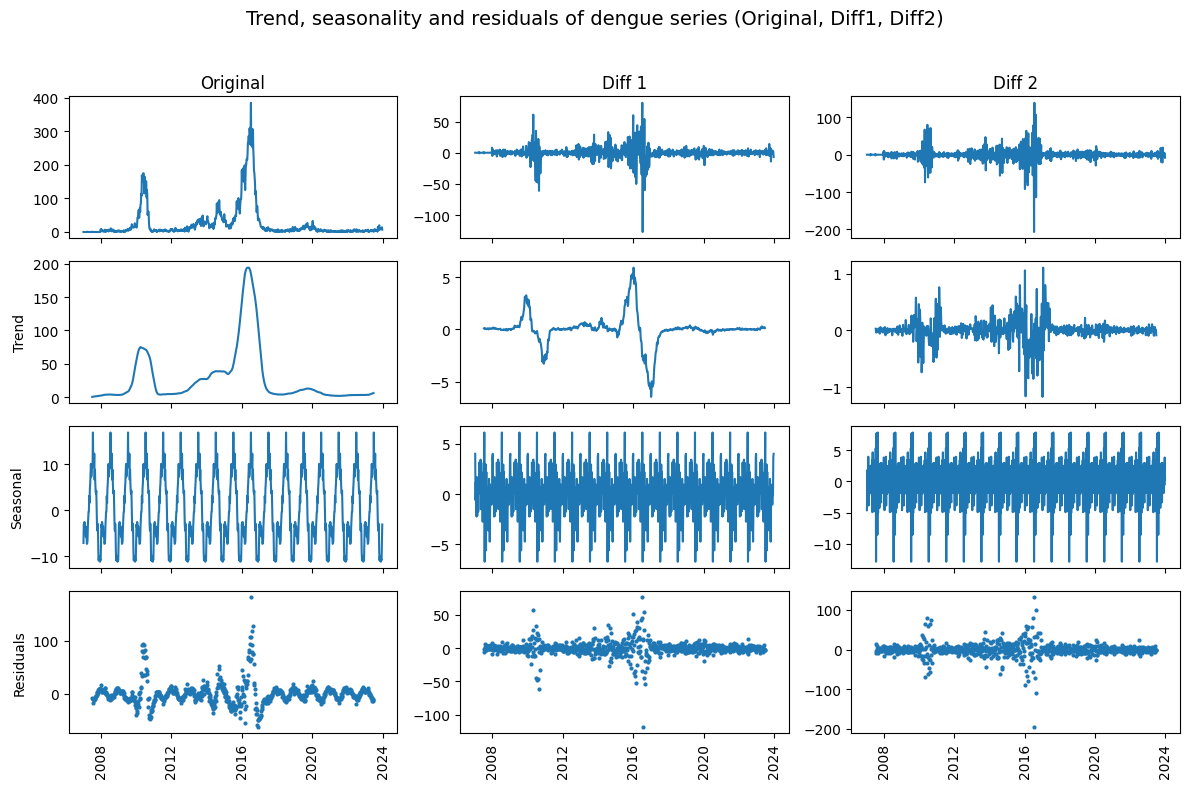

In [18]:
# 4 filas × 3 columnas
fig, axes = plt.subplots(4, 3, figsize=(12, 8), sharex=True)

for col, (serie, title) in enumerate(zip(series_list, titles)):
    result = seasonal_decompose(serie, model='additive', period=52)

    # Observed
    axes[0, col].plot(result.observed)
    axes[0, col].set_title(title)
    axes[0, col].tick_params(labelbottom=False)

    # Trend
    axes[1, col].plot(result.trend)
    axes[1, col].set_ylabel("Trend" if col == 0 else "")
    axes[1, col].tick_params(labelbottom=False)

    # Seasonal
    axes[2, col].plot(result.seasonal)
    axes[2, col].set_ylabel("Seasonal" if col == 0 else "")
    axes[2, col].tick_params(labelbottom=False)

    # Residuals (puntos pequeños)
    axes[3, col].plot(result.resid, marker='o', linestyle='none', markersize=2)
    axes[3, col].set_ylabel("Residuals" if col == 0 else "")

    # ✔️ Mostrar ticks del eje X solo aquí
    axes[3, col].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[3, col].xaxis.set_major_locator(mdates.YearLocator(4))  # cada 4 años
    axes[3, col].tick_params(axis='x', rotation=90)

fig.suptitle("Trend, seasonality and residuals of dengue series (Original, Diff1, Diff2)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

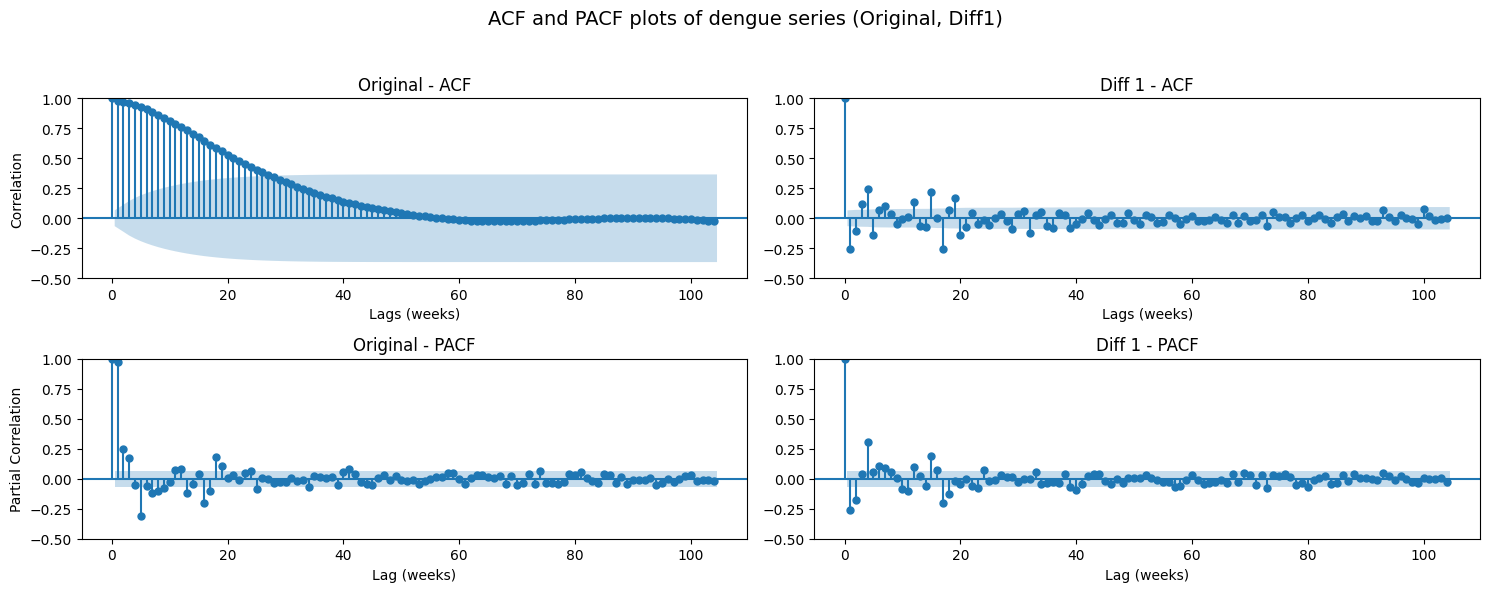

In [19]:
series_list = [s0, s1]
titles = ["Original", "Diff 1"]

# Figure with 2 rows (ACF, PACF) and 3 columns (series)
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle("ACF and PACF plots of dengue series (Original, Diff1)", fontsize=14)

for col, (serie, title) in enumerate(zip(series_list, titles)):

    # ACF (row 0)
    plot_acf(serie, ax=axes[0, col], lags=52*2, zero=True)
    axes[0, col].set_title(f"{title} - ACF")
    axes[0, col].set_ylim(-0.5, 1)
    axes[0, col].set_xlabel("Lags (weeks)")
    axes[0, col].set_ylabel("Correlation" if col == 0 else "")

    # PACF (row 1)
    plot_pacf(serie, ax=axes[1, col], lags=52*2, zero=True, method='ywm')
    axes[1, col].set_title(f"{title} - PACF")
    axes[1, col].set_ylim(-0.5, 1)
    axes[1, col].set_xlabel("Lag (weeks)")
    axes[1, col].set_ylabel("Partial Correlation" if col == 0 else "")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [20]:
# ------------------------------------------------------------
# Obtener PACF numéricamente
# ------------------------------------------------------------

nlags = 52 * 2  # igual que en la gráfica
pacf_values, confint = pacf(df[target], nlags=nlags, method='ywm', alpha=0.05)

# Crear DataFrame con lag, PACF y límites de confianza
pacf_df = pd.DataFrame({
    'lag': range(len(pacf_values)),
    'pacf': pacf_values,
})

# Calcular valor absoluto y significancia
pacf_df['abs_pacf'] = pacf_df['pacf'].abs()

# Ordenar por magnitud absoluta
pacf_df_sorted = pacf_df.iloc[1:].sort_values(by='abs_pacf', ascending=False)

print("\n🔢 Lags ordenados por magnitud (PACF):")
print(pacf_df_sorted.head(10))


🔢 Lags ordenados por magnitud (PACF):
    lag      pacf  abs_pacf
1     1  0.977157  0.977157
5     5 -0.308670  0.308670
2     2  0.247559  0.247559
16   16 -0.205164  0.205164
18   18  0.177744  0.177744
3     3  0.173546  0.173546
7     7 -0.115906  0.115906
13   13 -0.115403  0.115403
19   19  0.107259  0.107259
8     8 -0.103758  0.103758


## Missing values

In [21]:
# --- Missing values summary ---
def missing_summary(df, target_col='target'):
    df_check = df.drop(columns=[target_col], errors='ignore')
    missing = df_check.isnull().sum()
    missing_pct = (missing / len(df_check)) * 100

    summary = pd.DataFrame({
        'n_missing': missing,
        '%_missing': missing_pct
    }).sort_values('%_missing', ascending=False)

    print("🧾 Missing values summary:")
    print(summary)
    return summary

# Example:
missing_summary(df)


🧾 Missing values summary:
                       n_missing  %_missing
CASES                          0        0.0
PRECIPITATION_AVG_MAX          0        0.0
RUNOFF_AVG_MAX                 0        0.0
TEMPERATURE_AVG_MAX            0        0.0
WIND_AVG_MAX                   0        0.0
year                           0        0.0


,n_missing,%_missing
CASES,0,0.0
PRECIPITATION_AVG_MAX,0,0.0
RUNOFF_AVG_MAX,0,0.0
TEMPERATURE_AVG_MAX,0,0.0
WIND_AVG_MAX,0,0.0
year,0,0.0
